In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
import string
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer # lemmatizer
from nltk.tokenize import word_tokenize
from textblob import Word
from nltk.corpus import stopwords
from nltk.corpus import wordnet

# data augmentation
import nlpaug.augmenter.word as naw
import nlpaug.flow as nafc
from nlpaug.util import Action

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import StringLookup

2023-12-06 11:28:17.450698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/songyujun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/songyujun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/songyujun/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/songyujun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [40]:
fin_data = pd.read_csv("/Users/songyujun/Documents/GitHub/PIC16B---Project/fin_data.csv")
positive = pd.read_csv("/Users/songyujun/Documents/GitHub/PIC16B---Project/articles.csv")
print(fin_data.columns)
print(positive.columns)

Index(['Sentence', 'Sentiment'], dtype='object')
Index(['title', 'content'], dtype='object')


In [41]:
positive['Sentiment'] = 'positive'

In [42]:
# take half of positive and merge the title portion and the content portion into the fin_data, separately
rows = positive.shape[0]
positive = positive.sample(frac=1)
merge = positive.iloc[:int(rows/2)]

In [43]:
# title merge
title = merge[['title', 'Sentiment']]
title.rename(columns = {'title': 'Sentence'}, inplace = True)
data_t = pd.concat([fin_data, title], axis = 0)
data_t = data_t.reset_index()
data_t.drop(columns = 'index', inplace = True)
data_t = data_t.sample(frac=1)
data_t.groupby("Sentiment").apply(len)

Sentiment
negative     860
neutral     3130
positive    3095
dtype: int64

In [64]:
# number of negative insufficient
# try1: use data augmentation to increase the number, augment 1 negative into 3 new sentences
aug1 = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
aug2 = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action="substitute")
aug3 = naw.ContextualWordEmbsAug(model_path='roberta-base', action="substitute")

negative = data_t[data_t["Sentiment"] == "negative"]

In [66]:
negative_aug1 = negative["Sentence"].apply(aug1.augment) # don't run this again, so slow

In [77]:
negative_aug2 = negative["Sentence"].apply(aug2.augment) # same as above

In [78]:
negative_aug3 = negative["Sentence"].apply(aug3.augment) # same as above

In [81]:
# compare
print(negative.loc[7]["Sentence"])
print('\n')
print(negative_aug1.loc[7][0])
print('\n')
print(negative_aug2.loc[7][0])
print('\n')
print(negative_aug3.loc[7][0])

SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANGE RELEASE OCTOBER 14 , 2008 AT 2:45 PM The Company updates its full year outlook and estimates its results to remain at loss for the full year .


ssh communications network security corp stock and exchange release october 20th 14, 2008 at 2 : 45 pm the company updates its latest full 10 year market outlook further and estimates overall its business results to still remain at loss for the full year.


· fidelity security corp stock exchange release october 14, 2008 approximately 2 : 45 noon the gao provided a full year outlook which estimates its results to remain at loss for each previous year.


SSH Investments GROUP CORP STOCK EXCHANGE RELEASE OCTOBER 14, 2008 · 2:45 PM The Company updates recent full year earnings and estimates financial results to sit at levels at the 2012 year.


In [100]:
negative_1 = [i[0] for i in negative_aug1]
negative_1 = pd.DataFrame(negative_1)
negative_1.rename(columns = {0: "Sentence"}, inplace = True)
negative_1["Sentiment"] = "negative"
negative_2 = [i[0] for i in negative_aug2]
negative_2 = pd.DataFrame(negative_2)
negative_2.rename(columns = {0: "Sentence"}, inplace = True)
negative_2["Sentiment"] = "negative"
negative_3 = [i[0] for i in negative_aug3]
negative_3 = pd.DataFrame(negative_3)
negative_3.rename(columns = {0: "Sentence"}, inplace = True)
negative_3["Sentiment"] = "negative"

In [102]:
data_t = pd.concat([data_t, negative_1, negative_2, negative_3], axis = 0)

In [104]:
data_t.groupby("Sentiment").apply(len)

Sentiment
negative    3440
neutral     3130
positive    3095
dtype: int64

In [105]:
data_t.to_csv("negative_augmented_version.csv")

In [106]:
# baseline prediction
baseline = data_t.groupby("Sentiment").apply(len)
negative = baseline[0]
neutral = baseline[1]
positive = baseline[2]
baseline_pred = max(negative, neutral, positive) / np.sum([negative, neutral, positive])
baseline_pred

0.35592343507501295

In [107]:
# labeling train set
le = LabelEncoder()
data_t['Category'] = le.fit_transform(data_t['Sentiment'])
data_t.head()

,Sentence,Sentiment,Category
1583,The sales of the Tiimari segment fell by 4.0 %...,negative,0
3053,With the U.S. Federal Government putting a sta...,neutral,1
66,Finnish GeoSentric 's net sales decreased to E...,negative,0
4472,"In 2009 , Comptel slipped to a net loss of EUR...",negative,0
3471,The sellers were EOSS Innovationsmanagement an...,neutral,1


In [100]:
lemmatizer = WordNetLemmatizer()

# Function to convert NLTK's POS tags to WordNet's format
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# for .apply()
def lemma(x):
    tokens = word_tokenize(x)
    tagged = nltk.pos_tag(tokens)
    lemmatized_sentence = []
    
    for word, tag in tagged:
        wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
        
    return ' '.join(lemmatized_sentence)

In [105]:
x = "passed, worse, continents, slept"
lemma(x)

'pass , bad , continent , sleep'

In [108]:
# clean text so that no capitalized letter and no stopping words

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to convert NLTK's POS tags to WordNet's format
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# for .apply()
def lemma(x):
    tokens = word_tokenize(x)
    tagged = nltk.pos_tag(tokens)
    lemmatized_sentence = []
    
    for word, tag in tagged:
        wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
        
    return ' '.join(lemmatized_sentence)

def make_dataset(stop, df):
    
    # change into lower case first
    df['cleaned'] = df['Sentence'].apply(lambda x: x.lower())
    
    # remove stopwords
    df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    
    # stemming
    df['cleaned'] = df['cleaned'].apply(lambda x: lemma(x))
    
    data = tf.data.Dataset.from_tensor_slices((df['cleaned'], df['Category']))
    
    return data


In [109]:
stop = stopwords.words("english")

In [110]:
# preparation before modelling

# tensorflow dataset and test set
data_title = make_dataset(stop, data_t)

data_title = data_title.shuffle(buffer_size = len(data_title), reshuffle_each_iteration=False)
train_size = int(0.7*len(data_title))
val_size = int(0.2*len(data_title))
train = data_title.take(train_size)
val = data_title.skip(train_size).take(val_size)
test = data_title.skip(train_size + val_size)

print(len(train))
print(len(val))
print(len(test))

6765
1933
967


In [111]:
# remove punctuation
def remove_punc(input_data):
    no_punctuation = tf.strings.regex_replace(input_data,
                                             '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

In [112]:
# vectorize_layer

# only the top distinct words will be tracked
max_tokens = 3000

# each sentence will be a vector of length 25
sequence_length = 50

vectorize_layer = TextVectorization(
    standardize=remove_punc,
    max_tokens=max_tokens, # only consider this many words
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(train.map(lambda x, y: x))

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), [label]

train_vec = train.map(vectorize_text)
val_vec   = val.map(vectorize_text)
test_vec = test.map(vectorize_text)

In [113]:
# Model
model_t = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 10, name="embedding"),
  layers.Dropout(0.2), # one of the regularization
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(3)]
)

In [114]:
model_t.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          30000     
                                                                 
 dropout (Dropout)           (None, None, 10)          0         
                                                                 
 global_average_pooling1d (  (None, 10)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 3)                 33        
                                                                 
Total params: 30033 (117.32 KB)
Trainable params: 30033 (117.32 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [115]:
# compile and history
model_t.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model_t.fit(train_vec, epochs = 10, validation_data = val_vec, callbacks=[callback], verbose = True)

Epoch 1/10
6765/6765 [==============================] - 15s 2ms/step - loss: 1.0454 - accuracy: 0.4851 - val_loss: 0.9606 - val_accuracy: 0.6539
Epoch 2/10
6765/6765 [==============================] - 14s 2ms/step - loss: 0.8765 - accuracy: 0.6511 - val_loss: 0.8129 - val_accuracy: 0.6937
Epoch 3/10
6765/6765 [==============================] - 12s 2ms/step - loss: 0.7285 - accuracy: 0.7162 - val_loss: 0.7176 - val_accuracy: 0.7212
Epoch 4/10
6765/6765 [==============================] - 11s 2ms/step - loss: 0.6276 - accuracy: 0.7619 - val_loss: 0.6674 - val_accuracy: 0.7310
Epoch 5/10
6765/6765 [==============================] - 12s 2ms/step - loss: 0.5667 - accuracy: 0.7802 - val_loss: 0.6408 - val_accuracy: 0.7310
Epoch 6/10
6765/6765 [==============================] - 12s 2ms/step - loss: 0.5233 - accuracy: 0.8016 - val_loss: 0.6282 - val_accuracy: 0.7362
Epoch 7/10
6765/6765 [==============================] - 12s 2ms/step - loss: 0.4876 - accuracy: 0.8130 - val_loss: 0.6252 - val_ac

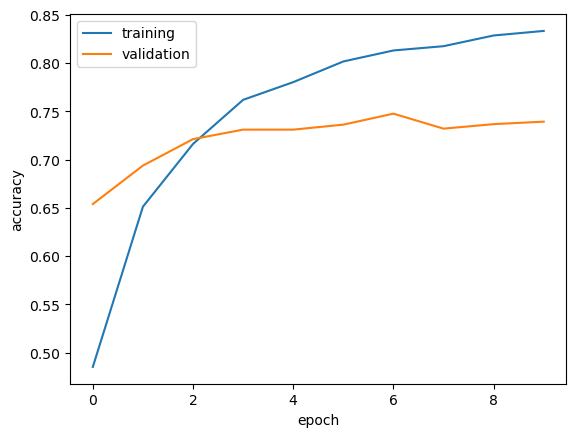

In [116]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

In [117]:
# test_vec2  = test_title.map(vectorize_text)
model_t.evaluate(test_vec)

967/967 [==============================] - 1s 1ms/step - loss: 0.6673 - accuracy: 0.7363


[0.6672511696815491, 0.7362978458404541]

In [ ]:
# content
content = merge[['content', 'Sentiment']]
content.rename(columns = {'content': 'Sentence'}, inplace = True)
data_c = pd.concat([fin_data, content], axis = 0)
data_c = data_c.reset_index()
data_c.drop(columns = 'index', inplace = True)
data_c = data_c.sample(frac=1)

le = LabelEncoder()
data_c['Category'] = le.fit_transform(data_c['Sentiment'])

# title test
# content_test = test[['content', 'Sentiment']]
# content_test.rename(columns = {'content' : 'Sentence'}, inplace = True)

# labeling test set
# content_test['Category'] = le.fit_transform(title_test['Sentiment']) + 2

data_content = make_dataset(stop, data_c)
# test_content = make_dataset(stop, content_test)

data_content = data_content.shuffle(buffer_size = len(data_title), reshuffle_each_iteration=False)
train_size = int(0.7*len(data_content))
val_size = int(0.2*len(data_content))
train = data_title.take(train_size)
val = data_title.skip(train_size).take(val_size)
test = data_title.skip(train_size + val_size)

train_vec = train.map(vectorize_text)
val_vec   = val.map(vectorize_text)
test_vec = val.map(vectorize_text)

# Model
model_c = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 10, name="embedding"),
  layers.Dropout(0.2), # one of the regularization
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(3)]
)

In [ ]:
# compile and history
model_c.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model_c.fit(train_vec, epochs = 10, validation_data = val_vec, callbacks=[callback], verbose = True)

Epoch 1/10
4959/4959 [==============================] - 23s 4ms/step - loss: 0.9552 - accuracy: 0.5350 - val_loss: 0.9048 - val_accuracy: 0.6366
Epoch 2/10
4959/4959 [==============================] - 20s 4ms/step - loss: 0.8123 - accuracy: 0.6808 - val_loss: 0.7834 - val_accuracy: 0.6718
Epoch 3/10
4959/4959 [==============================] - 24s 5ms/step - loss: 0.6766 - accuracy: 0.7379 - val_loss: 0.7162 - val_accuracy: 0.6824
Epoch 4/10
4959/4959 [==============================] - 19s 4ms/step - loss: 0.5896 - accuracy: 0.7679 - val_loss: 0.6828 - val_accuracy: 0.6958
Epoch 5/10
4959/4959 [==============================] - 22s 4ms/step - loss: 0.5283 - accuracy: 0.7881 - val_loss: 0.6747 - val_accuracy: 0.7001
Epoch 6/10
4959/4959 [==============================] - 19s 4ms/step - loss: 0.4949 - accuracy: 0.7965 - val_loss: 0.6776 - val_accuracy: 0.7057
Epoch 7/10
4959/4959 [==============================] - 19s 4ms/step - loss: 0.4714 - accuracy: 0.8066 - val_loss: 0.6870 - val_ac

In [ ]:
model_c.evaluate(test_vec)

1417/1417 [==============================] - 6s 4ms/step - loss: 0.6976 - accuracy: 0.7043


[0.6975756287574768, 0.7043048739433289]

In [ ]:
# LSTM later

In [118]:
starbucks = pd.read_csv("/Users/songyujun/Documents/GitHub/PIC16B---Project/Starbucks_news.csv")

In [ ]:
def make_dataset(stop, df):
    # change into lower case first
    df['cleaned'] = df['Sentence'].apply(lambda x: x.lower())
    
    # remove stopwords
    df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    
    # stemming
    df['cleaned'] = df['cleaned'].apply(lambda x: lemma(x))
    
    data = tf.data.Dataset.from_tensor_slices((df['cleaned']))
    
    return data

def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

In [124]:
title = pd.DataFrame(starbucks['title'])
title.rename(columns = {'title': "Sentence"}, inplace = True)
title["Category"] = 0

In [125]:
title = make_dataset(stop, title)

In [126]:
real = title.map(vectorize_text)

In [127]:
attitude = model_t.predict(real).argmax(axis=1)

7488/7488 [==============================] - 7s 972us/step


In [133]:
sum(attitude==0), sum(attitude==1), sum(attitude==2)

(2447, 1208, 3833)

In [137]:
starbucks['score1'] = attitude

In [144]:
# check accuracy
check = starbucks[:5][["title", "score1"]]
for i in range(5):
    print('"', check.iloc[i]["title"], '"' , "scores: ", check.iloc[i]["score1"])
    print('\n')

" [Targeted] Chase Offers/BofA: Save 10% at Starbucks, up to $3 Cashback " scores:  2


" IAC Stock Has Soared Through Spinoffs And Vimeo Is Next. Here’s Why You Should Take A Look. " scores:  2


" ESG Flows Drive Clean Energy To Fresh Highs " scores:  2


" McDonald's will launch 3 chicken sandwiches next month as it doubles down on chicken " scores:  2


" Starbucks (SBUX) Gains But Lags Market: What You Should Know " scores:  0




In [149]:
price_pred = starbucks[["date", "score1"]]

In [150]:
price_pred = price_pred.groupby("date").apply(np.mean)

In [153]:
price_pred = pd.DataFrame(price_pred)

In [155]:
price_pred.rename(columns = {0: "score"}, inplace = True)

In [156]:
price_pred.to_csv("scores.csv")

In [6]:
price_pred = pd.read_csv("scores.csv")

In [1]:
from yahoo_fin import stock_info as si

company = si.get_data('sbux')
company = company.loc["2021-01-04":] # 01-04 is the first Monday of 2021.
company["date"] = company.index
company = company.reset_index()
company.drop(columns = "index", inplace = True)

In [69]:
date = company[['date']]
date

,date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08
...,...
731,2023-11-29
732,2023-11-30
733,2023-12-01
734,2023-12-04


In [71]:
date = date[date['date'] < "2023-11-15"]
date = date['date'].dt.strftime('%Y-%m-%d')

In [72]:
date = pd.DataFrame(date)

In [73]:
date

,date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08
...,...
717,2023-11-08
718,2023-11-09
719,2023-11-10
720,2023-11-13


In [7]:
price_pred

,date,score
0,2021-01-01,2.000000
1,2021-01-03,2.000000
2,2021-01-04,2.000000
3,2021-01-05,1.250000
4,2021-01-06,0.000000
...,...,...
911,2023-11-10,1.615385
912,2023-11-11,1.200000
913,2023-11-12,1.833333
914,2023-11-13,1.000000


In [77]:
date1 = date['date'].to_numpy()
date2 = price_pred["date"].to_numpy()
score = price_pred["score"].to_numpy()

In [92]:
score_pred = []
memory = 0
indic = 0

for i in range(len(score)):
    
    if i < len(date1) and date1[i] not in date2:
        score_pred.append(None)
        
    if date2[i] not in date1:
        memory += score[i]
        indic += 1
        continue 
        
    if memory != 0:
        score_append = (memory + score[i]) / (indic+1)
        score_pred.append(score_append)
        memory = 0
        indic = 0
        continue
    
    score_pred.append(score[i])
        

In [96]:
for i in range(len(score_pred)):
    if score_pred[i] is None:
        for j in range(1, i):
            if score_pred[i-j] is not None and score_pred[i+j] is not None:
                avg = (score_pred[i-j] + score_pred[i+j]) / 2
                score_pred[i] = avg
                break

In [99]:
final_score = pd.DataFrame(score_pred)
final_score.rename(columns = {0: "Score"}, inplace = True)
final_score.to_csv("final_score.csv")